# Задание.

В компании накопился достаточно большой объем данных о поведении клиента. Есть данные о самих клиентах, кто совершает на платформе заказы готовой еды. Есть данные о заказах (когда, сколько, на какую сумму и куда была заказа еда).Есть дополнительно информация о сессиях пользователей приложение и справочные данные о ресторанах и о курьерах.

В качестве тестового задания мы предлагаем исследовать данные о клиентах и их покупках и предложить гипотезы для роста продаж.

Подсказываем, что это может быть: 
	когортный анализ пользователей;
	исследование пользователей, кто не сделал заказ в определенное время;
	исследование частотности заказов и т.д.

Семпл данных выложен по ссылке:
https://github.com/itruf/analytic-demo-data


В результате выполнения задачи мы ожидаем увидеть:
	дашборд;
	гипотезы по увеличению продаж.

Дашборд, как инструмент, должен подтверждать почему вы построили именно такие гипотезы и доказывать на цифрах их жизнеспособность.

<a name="1common."></a>
[Шаг 1. Загрузим данные и подготовимся к их анализу](#1.)
  
[Шаг 2.Предобработка данных и общее исследование](#2.)
* [2.1 Анализ NAN в application_id](#2.1)
* [2.2 Анализ NAN в place_id](#2.2)
* [2.3 Анализ NAN в latitude\longitude](#2.3)
* [2.4 Поиск хакеров](#2.4)
* [2.5 Коллекционеры одноразовой посуды](#2.5)
* [2.6 Заказы из разных мест](#2.6)
* [2.7 Аномалии с доставкой](#2.7)
* [2.8 Оценка заказов и клиентов](#2.8)

[Шаг 3. Кагортный анализ](#3.)

<a name="1."></a><br/>
<font size="5"><b>1. Загрузим данные и подготовимся к их анализу</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
import time
# импорт библиотеки pandas
import pandas as pd 

import copy
# библиотеки для визуализации
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# импортируем библиотеки для мат.расчетов
import numpy as np
import scipy.stats as st

# игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('/home/catfox/Downloads/data.csv')
df.tail()

,id,price,full_price,final_price,agent_amount,agent_percent,application_id,client_id,created,delivery_type,payment_type,is_service_delivery,latitude,longitude,make_fast_as_possible,date_of_finish_cooking,date_of_visit,place_id,state,user_count
114396,575d8044-c858-4c56-a733-26c3000a9947,570.0,770.0,770.0,114.0,20.0,NaN,cb3ffcd7-29a3-4ea7-9cc9-3af707638411,2018-03-09T11:00:33.531+03:00,default,card-online,True,45.020341,38.960823,True,2018-03-10T10:30:00.000+03:00,2018-03-10T11:00:00.000+03:00,18f6c6e3-d0a1-4ccb-82fb-6976db97ed9e,finished,1
114397,308f4e71-acc1-472f-b537-a08fd2f815b0,950.0,1150.0,1150.0,190.0,20.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,302802b6-e7cc-4f87-8798-7be8b16df83b,2019-02-26T11:50:46.519+03:00,default,cash,True,45.017557,39.052379,True,2019-02-26T12:20:00.000+03:00,2019-02-26T12:50:00.000+03:00,c618b751-d67c-4e02-b6ec-14bb182891a0,finished,0
114398,325cc760-2a43-485c-9dbb-9816c385e005,1005.0,1005.0,1005.0,301.5,30.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,910c43dd-a992-49ae-bb50-2550c72d4e59,2019-02-26T11:47:10.286+03:00,default,cash,True,45.064164,39.042184,True,2019-02-26T12:27:00.000+03:00,2019-02-26T12:50:00.000+03:00,d7e78406-9e78-407d-b257-165844a14ab5,finished,0
114399,068bf7e5-e256-4b85-8b49-9b036bfa2e9c,950.0,1150.0,1150.0,190.0,20.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,302802b6-e7cc-4f87-8798-7be8b16df83b,2019-02-26T11:46:55.097+03:00,default,cash,True,45.035744,39.015540,True,2019-02-26T12:16:00.000+03:00,2019-02-26T09:00:00.000+03:00,c618b751-d67c-4e02-b6ec-14bb182891a0,canceled_bb,1
114400,ca25d261-8277-4ba1-be2d-87fc9cd62f6c,1080.0,1230.0,1230.0,324.0,30.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,612f56fa-e077-443e-90c1-0324d1db0190,2019-02-26T11:26:46.552+03:00,default,cash,True,45.056295,39.023005,True,2019-02-26T11:51:00.000+03:00,2019-02-26T09:00:00.000+03:00,5cc89d74-7c6b-4e8a-80a5-93c64dc5c91c,canceled_bb,1


* id – id заказа
* price – цена товаров в заказе (₽)
* full_price – цена товаров и доставки в заказе (₽)
* final_price – цена товаров и доставки в заказе с учетом всех скидок (₽)
* agent_amount – размер агентской комиссии (₽)
* agent_percent – размер агентской комиссии (%)
* application_id – ID клиентского приложения, откуда был сделан заказ
* client_id – ID клиента
* created – дата создания заказа
* delivery_type – enum тип доставки заказа
* payment_type – enum тип оплаты заказа
* is_service_delivery – осуществляется ли доставка курьерами сервиса
* latitude – широта адреса доставки
* longitude – долгота адреса доставки
* make_fast_as_possible – доставить "как можно скорее"
* date_of_finish_cooking – дата приготовления заказа (план)
* date_of_visit – дата доставки заказа (план)
* place_id – id места, откуда был сделан заказ
* state - enum статус заказа
* user_count – на сколько персон нужны приборы

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114401 entries, 0 to 114400
Data columns (total 20 columns):
id                        114401 non-null object
price                     114401 non-null float64
full_price                114401 non-null float64
final_price               114401 non-null float64
agent_amount              114401 non-null float64
agent_percent             114401 non-null float64
application_id            111101 non-null object
client_id                 114401 non-null object
created                   114401 non-null object
delivery_type             114401 non-null object
payment_type              114401 non-null object
is_service_delivery       114401 non-null bool
latitude                  112629 non-null float64
longitude                 112629 non-null float64
make_fast_as_possible     114401 non-null bool
date_of_finish_cooking    114401 non-null object
date_of_visit             114401 non-null object
place_id                  114319 non-null object
stat

In [4]:
df.isnull().sum()

id                           0
price                        0
full_price                   0
final_price                  0
agent_amount                 0
agent_percent                0
application_id            3300
client_id                    0
created                      0
delivery_type                0
payment_type                 0
is_service_delivery          0
latitude                  1772
longitude                 1772
make_fast_as_possible        0
date_of_finish_cooking       0
date_of_visit                0
place_id                    82
state                        0
user_count                   0
dtype: int64

1. 114401 строк, 20 столбцов
2. Столбцы price, full_price, final_price - имееют формат float. Это допустимо, но надо проверть целесобразно или нет.
3. Наны в столбцах application_id, latitude, longitude, place_id.

<a name="2."></a><br/>
<font size="5"><b>2. Предобработка данных</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

1. Проведем ряд проверок убедится, что данные готовы к анализу.
2. Ввод дополительных столбцов для анализа
3. Попробуем определить природу возникновения нанов, затем заполним их по-возможности.

In [5]:
# проверим оправданность типа даных float64 для столбца price 
# достаточно подсчитать сумму по столбцу с типом данных float64 и int
print(df['price'].sum()-df['price'].astype(int).sum())
print(df['full_price'].sum()-df['full_price'].astype(int).sum())
print(df['final_price'].sum()-df['final_price'].astype(int).sum())

177.21000000834465
0.19999998807907104
446.3899999856949


In [6]:
# проверим, все ли заказы уникальны
df.id.nunique()

114401

In [7]:
# проверим, что в базе нет косяков - один заказ два разных клиента
df.groupby('id').agg({'client_id':'nunique'}).client_id.unique()

array([1])

Все ок, с заказами.
У нас в столбцах с датами формат строка, исправим это.

In [8]:
df.created = df.created.astype('datetime64[ns]')
df.date_of_finish_cooking = df.date_of_finish_cooking.astype('datetime64[ns]')
df.date_of_visit = df.date_of_visit.astype('datetime64[ns]')

In [9]:
# время готовки заказа
# введем столбец ожидание от заказа до доставки - waiting_order
# время на доставку - delivery_time
df['prepaire_time'] = ((df.date_of_finish_cooking - df.created).dt.total_seconds()/60).round()
df['delivery_time'] = ((df.date_of_visit - df.created).dt.total_seconds()/60).round()
df['waiting_order'] = ((df.date_of_visit - df.date_of_finish_cooking).dt.total_seconds()/60).round()

In [10]:
df['dt']=df['created'].dt.date
df['weekday']=df['created'].dt.weekday
df['hour']=df['created'].dt.hour
df['month']=df['created'].dt.month
df['month2']= df['created'].astype('datetime64[M]')
df['year']=df['created'].dt.year
df['week'] = df['created'].dt.week
df.head()

,id,price,full_price,final_price,agent_amount,agent_percent,application_id,client_id,created,delivery_type,...,prepaire_time,delivery_time,waiting_order,dt,weekday,hour,month,month2,year,week
0,3b182b55-2816-418b-930f-eb30a7e0bee5,1459.0,1749.0,1749.0,437.7,30.0,e0f8cc88-4a5e-4870-b668-50f1a95ca326,bad3d57d-4760-43e3-891f-c6f6fb123499,2019-05-29 09:43:51.299,long_distance,...,24.0,76.0,52.0,2019-05-29,2,9,5,2019-05-01,2019,22
1,8faeffb3-28b9-4a99-bbd9-8a94128c1b16,370.0,560.0,560.0,92.5,25.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,f2eaebdf-7878-463a-91b9-20616fdcd4cf,2019-06-17 17:18:55.371,default,...,24.0,46.0,22.0,2019-06-17,0,17,6,2019-06-01,2019,25
2,cccccce8-e75c-4ab3-892d-182ebb0f5776,860.0,1000.0,1000.0,197.8,23.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,f6ef3117-23fb-4a89-93d6-6a13092c27f6,2019-06-10 15:09:35.273,default,...,24.0,50.0,26.0,2019-06-10,0,15,6,2019-06-01,2019,24
3,997cb653-ef4c-4c4b-b251-308b66ad2aa0,2860.0,2860.0,2860.0,657.8,23.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,bd8a7330-289c-4fc1-b8f9-0f4700bdc26d,2019-06-10 14:38:28.019,default,...,25.0,52.0,27.0,2019-06-10,0,14,6,2019-06-01,2019,24
4,70b630d5-c93e-4adf-9db0-01a90ccbae50,350.0,750.0,750.0,0.0,0.0,7f74022a-0930-435d-baf4-d28672d08889,e73e2099-ae9a-43f4-9c7c-31e005d59ad5,2019-06-17 17:23:18.112,long_distance,...,17.0,57.0,40.0,2019-06-17,0,17,6,2019-06-01,2019,25


In [11]:
# клиентский бонус
df['client_bonus']=df.full_price-df.final_price

<a name="2.1"></a><br/>
<font size="4"><b>2.1 Анализ NAN в application_id</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [20]:
# проверка делают ли клиенты заказы из разных приложений
df[df.application_id.notnull()].groupby('client_id').agg({'application_id':'nunique'}).sort_values('application_id',ascending=False).head(10)

,application_id
client_id,
fa507a25-a216-47b0-bc49-e15e3ccf7e93,4
731071fc-a191-41d9-abe5-507b8d41ebb8,4
5832830d-0511-4697-a22c-38b61600dc60,4
31c3ff1f-6fc4-41dd-86ce-8922604c8dc6,4
26f17bbc-7c45-460f-b40a-865a2859e12d,4
0e1dec20-a01e-4bba-a8cd-50ddee9487c6,4
a0f33d0f-87c7-4da1-994a-c38127d26f54,4
62864d89-7a1e-48ae-bd34-61535f019e42,4
6f92888b-443b-45ee-8ccf-dbc0133e664e,4


In [21]:
df.application_id = df.application_id.fillna('unknow')

In [22]:
graf_app1 = df.groupby('application_id').agg({'id':'count'}).reset_index()
graf_app1 = graf_app1.rename(columns={'id': 'count_of_orders'})
graf_app2 = df.query('state!="finished"').groupby(['application_id']).agg({'id':'count'}).reset_index()
graf_app2 = graf_app2.rename(columns={'id': 'count_of_canceled_orders'})
graf_app = graf_app1.merge(graf_app2, on = 'application_id')
graf_app['%_of_canceled_orders'] = (graf_app.count_of_canceled_orders/graf_app.count_of_orders*100).round(1)

In [23]:
graf_app

,application_id,count_of_orders,count_of_canceled_orders,%_of_canceled_orders
0,3d8844af-8166-4397-ba49-63bd008a76d7,6874,316,4.6
1,7f74022a-0930-435d-baf4-d28672d08889,4153,193,4.6
2,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,71035,3018,4.2
3,cd7b52a3-f45b-447f-9ad1-11a063020270,9625,614,6.4
4,e0f8cc88-4a5e-4870-b668-50f1a95ca326,19414,1123,5.8
5,unknow,3300,318,9.6


### unknow app дает больше всего процент отмен заказов.

In [24]:
df.query('state!="finished"').month2.nunique()

23

In [25]:
df.query('state=="finished"').month2.nunique()

24

In [26]:
df.query('application_id=="unknow"').groupby('state').agg({'id':'count'})

,id
state,
canceled,45
canceled_bb,137
canceled_place,136
finished,2982


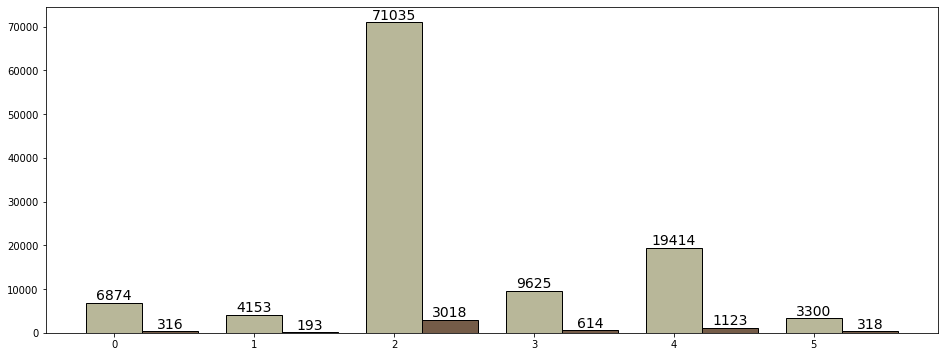

In [27]:
length = len(graf_app)
x_labels = graf_app.application_id.unique().tolist()
fig, ax = plt.subplots(figsize=(16,6))
width = 0.4 # width of bar
x = np.arange(length)
#строим бар
ax.bar(x, graf_app.count_of_orders, width, color='#B8B799', label='klass_0',ec='black' )
#делаем подписи
for i, val in enumerate(graf_app.count_of_orders.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom',
             fontdict={'fontweight':500, 'size':14})
ax.bar(x + width, graf_app.count_of_canceled_orders, width, color='#755C48', label='klass_1',ec='black')
for i, val in enumerate(graf_app.count_of_canceled_orders.values):
    plt.text(i+width, val, int(val), horizontalalignment='center', verticalalignment='bottom', 
             fontdict={'fontweight':500, 'size':14})   

Text(0, 0.5, 'Количество')

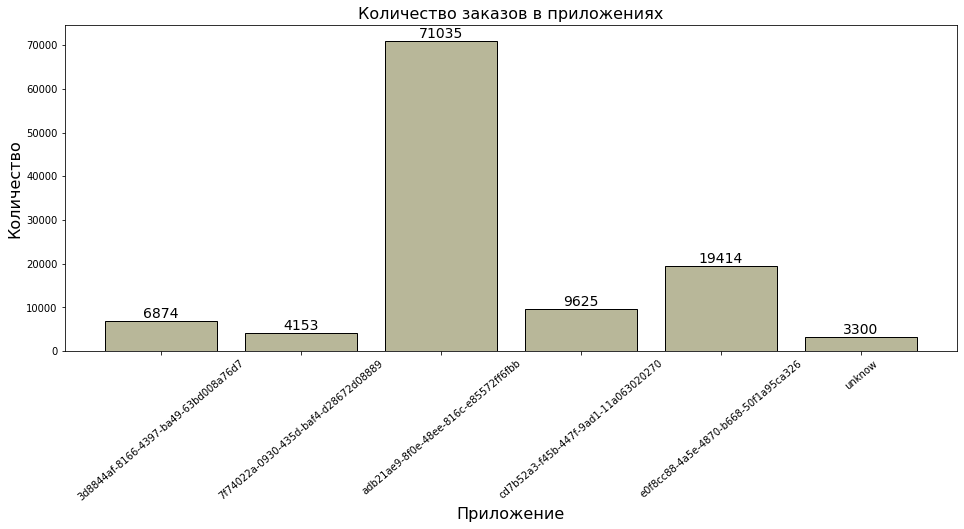

In [28]:
fig, ax = plt.subplots(figsize=(16,6))
ax.bar(graf_app.application_id, graf_app.count_of_orders,color='#B8B799', ec='black') 
for i, val in enumerate(graf_app.count_of_orders.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':14})
plt.title('Количество заказов в приложениях',size=16)
plt.gca().set_xticklabels(graf_app.application_id, rotation=40,size=10)
plt.xlabel('Приложение',size=16)
plt.ylabel('Количество',size=16)

In [29]:
df.query('state!="finished"').groupby(['application_id']).agg({'id':'count'})

,id
application_id,
3d8844af-8166-4397-ba49-63bd008a76d7,316
7f74022a-0930-435d-baf4-d28672d08889,193
adb21ae9-8f0e-48ee-816c-e85572ff6fbb,3018
cd7b52a3-f45b-447f-9ad1-11a063020270,614
e0f8cc88-4a5e-4870-b668-50f1a95ca326,1123
unknow,318


In [30]:
df.groupby(['application_id','state']).agg({'id':'count'})

id
application_id                       state                
3d8844af-8166-4397-ba49-63bd008a76d7 canceled_bb       248
                                     canceled_place     68
                                     finished         6558
7f74022a-0930-435d-baf4-d28672d08889 canceled_bb       102
                                     canceled_place     91
                                     finished         3960
adb21ae9-8f0e-48ee-816c-e85572ff6fbb canceled            3
                                     canceled_bb      1885
                                     canceled_place   1130
                                     finished        68017
cd7b52a3-f45b-447f-9ad1-11a063020270 canceled            1
                                     canceled_bb       428
                                     canceled_place    185
                                     finished         9011
e0f8cc88-4a5e-4870-b668-50f1a95ca326 canceled           43
                                     canceled_bb       628
                                     canceled_place    452
                                     finished        18291
unknow                               canceled           45
                                     canceled_bb       137
                                     canceled_place    136
                                     finished         2982

In [31]:
df.query('state != "finished"').groupby('state').agg({'id':'count'})

,id
state,
canceled,92
canceled_bb,3428
canceled_place,2062


### canceled - клиент отменил
### canceled_bb - broniboy не смог выполнить
### canceled_place - отмена по вине заведения

<a name="2.2"></a><br/>
<font size="4"><b>2.2 Анализ NAN в place_id</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [32]:
df[df['place_id'].isnull()].dt.unique()

array([datetime.date(2019, 5, 30), datetime.date(2019, 6, 11),
       datetime.date(2019, 6, 21), datetime.date(2019, 6, 12),
       datetime.date(2019, 6, 1), datetime.date(2019, 6, 3),
       datetime.date(2019, 6, 19), datetime.date(2019, 6, 13),
       datetime.date(2019, 6, 5), datetime.date(2019, 6, 6),
       datetime.date(2019, 6, 14), datetime.date(2019, 5, 10),
       datetime.date(2019, 5, 12), datetime.date(2019, 5, 13),
       datetime.date(2019, 6, 15), datetime.date(2019, 5, 16),
       datetime.date(2019, 6, 22), datetime.date(2019, 6, 16),
       datetime.date(2019, 5, 18), datetime.date(2019, 5, 20),
       datetime.date(2019, 5, 24), datetime.date(2019, 6, 9),
       datetime.date(2019, 5, 26), datetime.date(2019, 6, 24),
       datetime.date(2019, 4, 30), datetime.date(2019, 5, 1),
       datetime.date(2019, 7, 25), datetime.date(2019, 6, 25),
       datetime.date(2019, 5, 3), datetime.date(2019, 6, 26),
       datetime.date(2019, 5, 5), datetime.date(2019, 6, 27),


In [33]:
df[df['place_id'].isnull()].dt.nunique()

55

In [34]:
df['place_id']= df['place_id'].fillna('unknow')

In [35]:
df[df['place_id']=='unknow'].groupby('place_id').agg({'price':'sum','agent_amount':'sum'})

,price,agent_amount
place_id,,
unknow,0.0,0.0


<a name="2.3"></a><br/>
<font size="4"><b>2.3 Анализ NAN в GEO</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [36]:
df[df.longitude.isnull()].delivery_type.unique()

array(['default', 'long_distance', 'restaurant', 'high_demand'],
      dtype=object)

### почему не записывались логи адресов доставки по отмененным заказам? 
### заказы без координат клиентов - при самовывозе

Ведь раньше была такая функция, судя по цитате "Заказы на доставку довольно быстро обогнали заказы, которые клиенты забирали сами в ресторане." из статьи https://vc.ru/tribuna/69485-kak-my-v-broniboy-biznes-model-iskali

### тогда бы логично если бы у нас был в поле delivery_type - ресторан,а у нас все подряд.

<a name="2.4"></a><br/>
<font size="4"><b>2.4 Поиск хакеров</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [37]:
find_hackers = df.groupby('client_id').agg({'client_bonus':'sum', 'price':'sum'}).reset_index()
find_hackers['delta'] = find_hackers['price'] - find_hackers['client_bonus'] 
find_hackers.query('delta<10').sort_values('delta').head(20)

,client_id,client_bonus,price,delta
24758,f97e2025-e356-488f-acfe-b2bc80342e5f,8755.0,7263.0,-1492.0
15848,9f86437b-575b-4fad-b9b7-0bc2cfd31c4f,5983.0,5550.0,-433.0
20398,ce2a5cab-f67f-4d42-921d-2ef99cfb7e91,15454.0,15050.0,-404.0
20959,d3af6c4a-6d9f-40f0-b181-96aef71d8b49,599.0,240.0,-359.0
17300,adcb79ca-f475-44dc-bc3b-1ce19697a99b,400.0,80.0,-320.0
16464,a5966e67-8851-4b7e-b1a9-e215fb7f34b8,996.0,701.0,-295.0
11187,71691071-5052-4aab-aef4-32a761401b4c,1964.0,1677.0,-287.0
16172,a2dc8ff5-b730-45ec-93ad-2f15894765b9,1000.0,790.0,-210.0
20422,ce76b30f-b8c3-4639-a1f3-a19be64c65cd,298.0,100.0,-198.0
17735,b21e1343-80ea-421f-b3fe-6504c5e18ac9,755.0,558.0,-197.0


In [38]:
find_hackers.query('delta<0').sort_values('price',ascending=False).head(20)

,client_id,client_bonus,price,delta
20398,ce2a5cab-f67f-4d42-921d-2ef99cfb7e91,15454.0,15050.0,-404.0
24758,f97e2025-e356-488f-acfe-b2bc80342e5f,8755.0,7263.0,-1492.0
15848,9f86437b-575b-4fad-b9b7-0bc2cfd31c4f,5983.0,5550.0,-433.0
11843,77b733d9-e4df-4b73-9f82-c71f436cb045,2953.0,2800.0,-153.0
3237,2126a5c7-e2d3-4a91-99c8-d18e6a30e11f,2000.0,1961.0,-39.0
11187,71691071-5052-4aab-aef4-32a761401b4c,1964.0,1677.0,-287.0
15085,9821bd7a-1c6a-4032-ae2f-204a0b0dbff2,1657.0,1569.0,-88.0
9218,5daa4bd0-cfc9-4f0d-9872-c9c7853bcef6,1500.0,1350.0,-150.0
7267,4a23f56f-b179-4f5c-ac32-8e82d4d0e4da,1467.0,1270.0,-197.0
1932,1348e6fa-fa96-4e0b-bb39-482dc97c30b3,1000.0,985.0,-15.0


In [39]:
hackers = find_hackers.query('delta<10').client_id.tolist()
len(hackers)

503

<a name="2.5"></a><br/>
<font size="4"><b>2.5 Коллекционеры одноразовой посуды</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [40]:
df.user_count.unique()

array([  1,   0,   2,   3,   4,   6,   7,  10,  14,   9,   5,   8,  19,
        15,  16,  25,  11,  12,  26,  50,  20,  23,  13,  30,  17, 620,
        36,  24,  35,  18,  70])

In [41]:
df.query('state=="finished"').groupby('user_count').agg({'id':'count','price':'mean'}).sort_values('user_count',ascending=False)

,id,price
user_count,,
620,1,620.000000
70,1,3520.000000
50,3,5602.000000
36,1,10500.000000
30,3,5660.000000
26,2,1719.500000
25,3,3336.333333
24,1,3300.000000
23,1,6462.000000


In [42]:
df.user_count.describe()

count    114401.000000
mean          1.364551
std           2.153561
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         620.000000
Name: user_count, dtype: float64

In [43]:
df.user_count.mode()

0    1
dtype: int64

### Заглушки поставить на одноразовую посуду с привязкой к сумме заказов. Сейчас видел в приложение нельзя больше 100 поставить.

<a name="2.6"></a><br/>
<font size="4"><b>2.6 Заказы из разных мест</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [45]:
# посмотрим как часто клиенты заказывают из разных мест.
df.groupby('client_id').agg({'longitude':'nunique'}).describe()

,longitude
count,25423.000000
mean,1.357354
std,1.781517
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,238.000000


In [46]:
df.groupby('client_id').agg({'longitude':'nunique'}).mode()

,longitude
0,1


In [47]:
df.groupby('client_id').agg({'longitude':'nunique'}).sort_values('longitude',ascending=False).head(10)

,longitude
client_id,
2d868cf8-bf22-424d-9cff-cbf66c01b189,238
26f17bbc-7c45-460f-b40a-865a2859e12d,66
f17815f0-6b23-4fc7-ba53-047603d23eb2,24
731071fc-a191-41d9-abe5-507b8d41ebb8,21
aafeb6aa-2e54-4b6a-8e68-1b1205e84980,20
ed1fe1ba-183e-437c-8262-0e058ffb70cb,15
e2ac8f0f-24ef-4db7-aef7-928855428c6a,13
f4fcbda3-2210-4621-82f7-393ef11699ed,12
d20aadef-96b0-4f84-b2e9-0950e6374442,12


In [68]:
df.groupby('place_id').agg({'latitude':'nunique'}).sort_values('latitude',ascending=False).head(10)

,latitude
place_id,
16850670-d37c-4647-b529-28911e16695d,2428
e701df97-0349-4872-a4f4-fd3707ec686d,1710
76edbec9-20d4-4672-89df-a5527377c5b8,1234
4ae8a68c-6622-4c4c-96a5-0f0aacbb7fd8,1106
18f6c6e3-d0a1-4ccb-82fb-6976db97ed9e,1051
14b07c54-519e-4e18-89cf-2e919a67ff5c,890
9c88c777-2a53-4006-bd60-e56b1c6a36aa,767
64f6b4d3-fa23-4f0c-9610-6951afeceec4,679
e95db384-04ab-4875-b20c-089a3c415140,655


<a name="2.7"></a><br/>
<font size="4"><b>2.7 Аномалии с доставкой</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

сколько отмененных заказов, причина.
сколько бы могли поднять денег

In [12]:
df['prepaire_time'].describe()

count    114401.000000
mean         39.853804
std         126.961951
min      -10070.000000
25%          24.000000
50%          25.000000
75%          29.000000
max        5757.000000
Name: prepaire_time, dtype: float64

In [13]:
df['delivery_time'].describe()

count    114401.000000
mean         39.116704
std         186.193718
min       -8676.000000
25%          47.000000
50%          53.000000
75%          61.000000
max        5787.000000
Name: delivery_time, dtype: float64

In [14]:
df['waiting_order'].describe()

count    114401.000000
mean         -0.737074
std         181.867820
min       -2850.000000
25%          23.000000
50%          27.000000
75%          31.000000
max       10105.000000
Name: waiting_order, dtype: float64

In [15]:
df[df['waiting_order'].astype(int)<0].agent_amount.sum()/df.agent_amount.sum()

0.027117592280721945

У нас есть аномальные заказы,посмотрим на них внимательно.

In [139]:
print(len(df[df['waiting_order'].astype(int)<0]))

3614


In [17]:
df[df['waiting_order'].astype(int)<0].state.unique()

array(['canceled_bb', 'canceled_place', 'finished'], dtype=object)

Посмотрим, есть ли аномалии с доставкой.
Логично, что дата оформления заказа created должна быть меньше фактической доставки date_of_visit.

С отменненными понятно, часть отвалилась по отказу заведения, другая часть - canceled_bb, но есть выполненые заказы. 
С отмененными заказами допустимо писать в столбец что-то условное, но с заказами со статусом finished - это неправильно, от слова совсем =)

In [18]:
print('Количество заказов с отрицательным временем доставки - {:.2%} от всех заказов'
      .format(len(df[df['waiting_order'].astype(int)<0].query('state=="finished"'))/len(df)))
print('Приложения на которых выявлен баг:','\n',df[df['waiting_order'].astype(int)<0]
      .query('state=="finished"').application_id.unique())
df[df['waiting_order'].astype(int)<0].query('state=="finished"').head(3)

Количество заказов с отрицательным временем доставки - 0.32% от всех заказов
Приложения на которых выявлен баг: 
 ['adb21ae9-8f0e-48ee-816c-e85572ff6fbb'
 '7f74022a-0930-435d-baf4-d28672d08889'
 'e0f8cc88-4a5e-4870-b668-50f1a95ca326'
 'cd7b52a3-f45b-447f-9ad1-11a063020270'
 '3d8844af-8166-4397-ba49-63bd008a76d7' nan]


,id,price,full_price,final_price,agent_amount,agent_percent,application_id,client_id,created,delivery_type,...,delivery_time,waiting_order,dt,weekday,hour,month,month2,year,week,client_bonus
942,0aaffcd6-02b7-40a4-b0ab-b6cab564dbf9,1.0,201.0,201.0,0.2,20.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,26f17bbc-7c45-460f-b40a-865a2859e12d,2019-02-27 09:37:23.202,default,...,-757.0,-917.0,2019-02-27,2,9,2,2019-02-01,2019,9,0.0
3729,b2e410fb-99b7-4383-90c8-dff68e97eee0,590.0,790.0,790.0,135.7,23.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,66b9e881-9bec-481e-9567-2594581eb79e,2019-02-05 20:28:02.470,default,...,42.0,-1420.0,2019-02-05,1,20,2,2019-02-01,2019,6,0.0
4168,d7b387fa-2243-4c96-9622-bc529cd94324,756.0,756.0,756.0,226.8,30.0,adb21ae9-8f0e-48ee-816c-e85572ff6fbb,371206ff-d234-4aac-a0eb-31dd390d3ea5,2018-11-27 20:09:10.728,default,...,51.0,-1407.0,2018-11-27,1,20,11,2018-11-01,2018,48,0.0


In [19]:
# Запишем косячные заказы для наших разрабов
ids_of_orders_with_minus_waiting_time_order = df[df['waiting_order'].astype(int)<0].id.tolist()
ids_of_fineshed_orders_with_minus_waiting_time_order = df[df['waiting_order'].astype(int)<0].id.tolist()

Тут косяк в данных, почему дата оформления позже даты выполнения заказа, вопрос к разработчикам.
Благо таких данных всего 0.32% от всех, но когда мы отмаштабируемся - это будет неприятным кейсом.
Баг возникает на всех приложениях.
Косячные заказы в списке ids_of_fineshed_orders_with_minus_waiting_time_order

<a name="2.8"></a><br/>
<font size="4"><b>2.8 Оценка заказов</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [55]:
df[df.state!='finished'].agent_amount.sum()

1233879.0

In [57]:
profit=df.groupby('state').agg({'agent_amount':'sum'}).reset_index()
profit

,state,agent_amount
0,canceled,11729.25
1,canceled_bb,743549.95
2,canceled_place,478599.80
3,finished,29384614.39


In [62]:
# оценка высокомаржинальных заказов
df.groupby('agent_percent').agg({'id':'nunique'}).sort_values('agent_percent',ascending=False)

,id
agent_percent,
32.0,4992
30.0,29540
27.0,951
25.0,14113
23.0,11303
22.0,1876
20.0,23652
18.0,706
17.0,1137


## исследование пользователей, кто не сделал заказ в определенное время;

In [69]:
df.groupby('client_id').agg({'id':'count'}).describe()

,id
count,25423.000000
mean,4.499902
std,12.533831
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,959.000000


In [70]:
ordersByclients = df.groupby('client_id').agg({'id':'count'})
ordersByclients.sort_values(by='id',ascending=False).head(10)

,id
client_id,
ed1fe1ba-183e-437c-8262-0e058ffb70cb,959
26f17bbc-7c45-460f-b40a-865a2859e12d,429
2d868cf8-bf22-424d-9cff-cbf66c01b189,331
5e471ed0-b640-46d2-aaf6-b7db5b55104a,257
0e1dec20-a01e-4bba-a8cd-50ddee9487c6,255
23b18acd-2eda-4e90-89c3-95fadb67648a,202
8f3a4b36-f2d5-4bf5-9ede-61dab57236c0,195
cb3ffcd7-29a3-4ea7-9cc9-3af707638411,193
b5cd0388-e6e4-480c-ac52-549ea942c507,188


Text(0.5, 1.0, 'Точечная диаграмма числа заказов на одного пользователя')

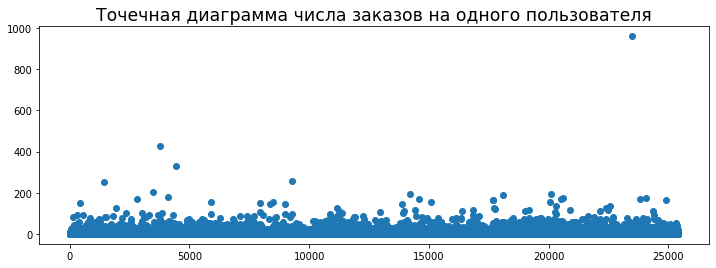

In [71]:
fig, ax = plt.subplots(figsize=(12,4))
x_values = pd.Series(range(0,len(ordersByclients)))
plt.scatter(x_values, ordersByclients['id'])
plt.title('Точечная диаграмма числа заказов на одного пользователя',fontsize='xx-large')

In [72]:
np.percentile(ordersByclients['id'], [90, 95, 99])

array([ 9., 17., 50.])

Не более 1% пользователей заказывали более 50раз. Необходимо выбрать 50 заказов на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей - "КИТОВ". 

Text(0.5, 1.0, 'Точечная диаграмма числа заказов на одного пользователя')

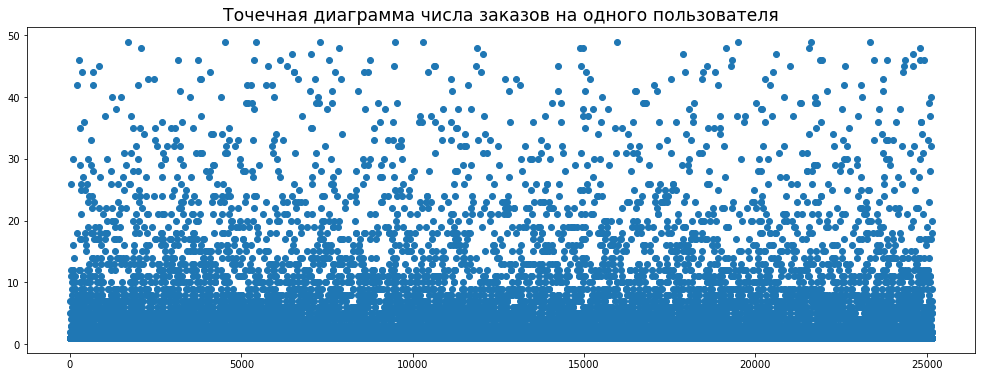

In [73]:
fig, ax = plt.subplots(figsize=(17,6))
x_values = pd.Series(range(0,len(ordersByclients[ordersByclients['id']<50])))
plt.scatter(x_values, ordersByclients[ordersByclients['id']<50])
plt.title('Точечная диаграмма числа заказов на одного пользователя',fontsize='xx-large')

In [74]:
kit_clients_orders = ordersByclients.query('id>50').index.tolist()
df.query('client_id not in @kit_clients_orders').groupby('client_id').agg({'id':'count'}).describe()

,id
count,25174.000000
mean,3.660841
std,6.015962
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,50.000000


In [129]:
# чаще всего
df.query('client_id not in @kit_clients_orders').groupby('client_id').agg({'id':'count'}).mode()

,id
0,1


Text(0.5, 1.0, 'Гистограмма заказов')

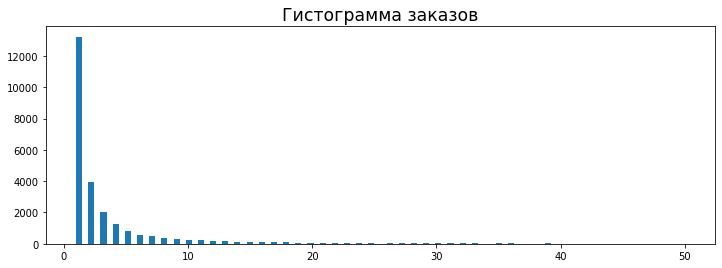

In [75]:
fig, ax = plt.subplots(figsize=(12,4))
plt.hist(df.query('client_id not in @kit_clients_orders').groupby('client_id').agg({'id':'count'}).reset_index()['id'],bins=100)
plt.title('Гистограмма заказов',fontsize='xx-large')

Text(0.5, 1.0, 'Точечная диаграмма числа заказов на одного пользователя')

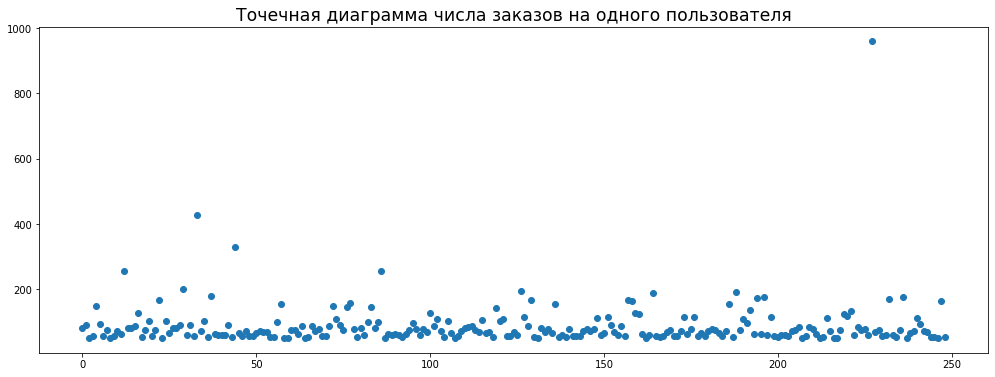

In [76]:
fig, ax = plt.subplots(figsize=(17,6))
x_values = pd.Series(range(0,len(ordersByclients[ordersByclients['id']>50])))
plt.scatter(x_values, ordersByclients[ordersByclients['id']>50])
plt.title('Точечная диаграмма числа заказов на одного пользователя',fontsize='xx-large')

Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

In [130]:
revenueByclients=df['final_price'].reset_index()

Text(0.5, 1.0, 'Точечный график стоимостей заказов')

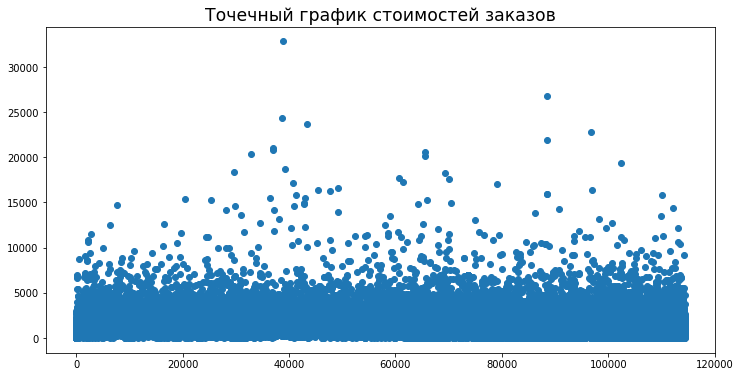

In [131]:
fig, ax = plt.subplots(figsize=(12,6))
x_values = pd.Series(range(0,len(revenueByclients)))
plt.scatter(x_values, df['final_price'])
plt.title('Точечный график стоимостей заказов',fontsize='xx-large')

Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [132]:
np.percentile(revenueByclients['final_price'], [95, 99])

array([2840., 4790.])

In [133]:
revenueByclients['final_price'].describe()

count    114401.000000
mean       1313.523591
std         951.273903
min           0.000000
25%         770.000000
50%        1115.000000
75%        1570.000000
max       32830.000000
Name: final_price, dtype: float64

In [134]:
kit_clients_orders = ordersByclients.query('id>50').index.tolist()
kit_clients_revenue = df.query('final_price>4790').client_id.tolist()

In [135]:
print(len(kit_clients_orders))
len(kit_clients_revenue)

249


1140

In [136]:
df.query('client_id == @kit_clients_revenue').final_price.sum()/df.final_price.sum()

0.20678092990931082

In [86]:
df.query('client_bonus!=0').groupby('client_bonus').agg({'id':'count'}).sort_values('id', ascending=False).head(20)

,id
client_bonus,
200.0,2016
300.0,711
225.0,166
500.0,149
140.0,97
90.0,89
1000.0,88
99.0,72
250.0,68


<a name="3."></a><br/>
<font size="5"><b>3. Кагортный анализ</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [90]:
df.created.max()-df.created.min()

Timedelta('714 days 09:55:43.449000')

У нас данные почти задва года, есть что проанализировать.

In [91]:
# выстроем данные в хронологическом порядке
df=df.sort_values('created',ascending = True).reset_index(drop=True)

In [92]:
count_orders_for_month = df.query('state=="finished"').groupby('month2').agg({'id':'nunique'}).reset_index()
count_orders_for_month = count_orders_for_month.rename(columns={'id': 'count_of_orders'})

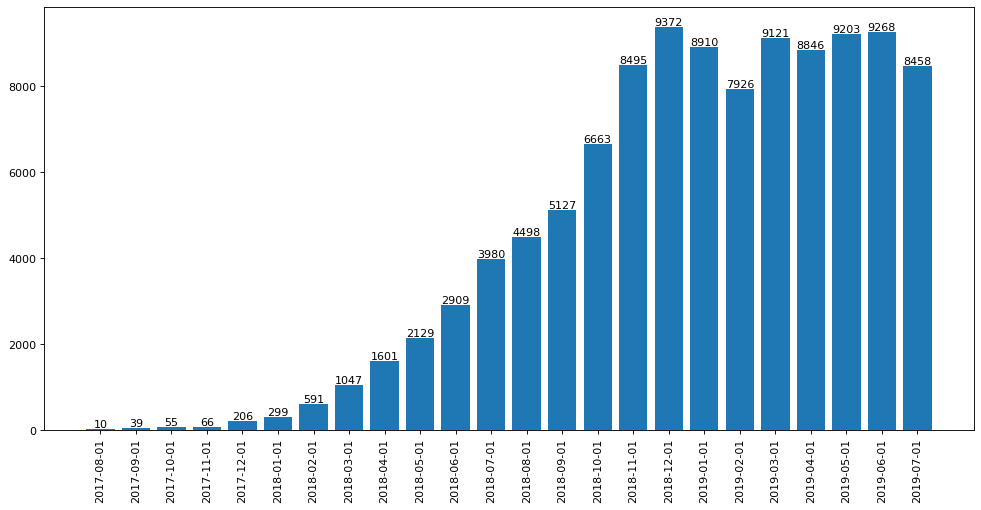

In [93]:
plt.figure(figsize=(15,7), dpi= 80)
plt.bar(count_orders_for_month['month2'].astype('str'),count_orders_for_month['count_of_orders'])
for i, val in enumerate(count_orders_for_month['count_of_orders'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom')
plt.gca().set_xticklabels(count_orders_for_month['month2'].astype('str'),rotation=90)
plt.show()

Цитата "За третий месяц мы выполнили ровно 55 заказов", прям как в статье - значит она реальная и данные тоже, супер!!
https://vc.ru/tribuna/69485-kak-my-v-broniboy-biznes-model-iskali

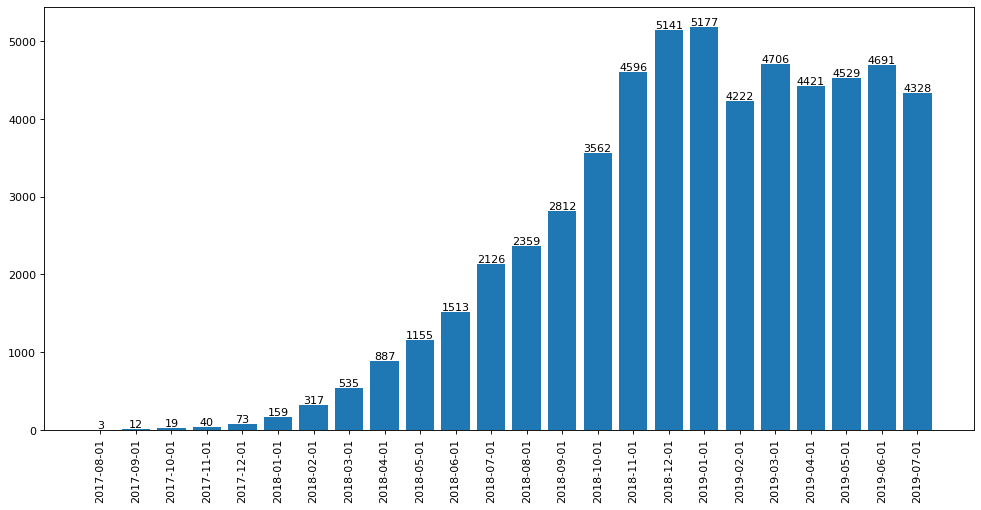

In [94]:
count_clients_per_month = df.groupby('month2').agg({'client_id':'nunique'}).reset_index()
count_clients_per_month = count_clients_per_month.rename(columns={'client_id': 'count_of_clients'})
plt.figure(figsize=(15,7), dpi= 80)
plt.bar(count_clients_per_month['month2'].astype('str'),count_clients_per_month['count_of_clients'])
for i, val in enumerate(count_clients_per_month['count_of_clients'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom')
plt.gca().set_xticklabels(count_clients_per_month['month2'].astype('str'),rotation=90)
plt.show()

In [95]:
first_visit_of_user=pd.DataFrame(df.groupby('client_id')['created'].min())
first_visit_of_user=first_visit_of_user.rename(columns={'created': 'first_visit_of_user'})
first_visit_of_user.head(1)

,first_visit_of_user
client_id,
00000220-a7ba-45cc-a38d-83cd28e44b4a,2019-01-19 14:09:10.876


Эту информацию добавим к информации о заказах.

In [96]:
df=df.merge(first_visit_of_user, on='client_id',how='left')
df.head(1)

,id,price,full_price,final_price,agent_amount,agent_percent,application_id,client_id,created,delivery_type,...,waiting_order,dt,weekday,hour,month,month2,year,week,client_bonus,first_visit_of_user
0,ca74a17e-1120-4152-a0c3-8c7a0bf0dda8,1610.0,1610.0,1610.0,161.0,10.0,unknow,ed1fe1ba-183e-437c-8262-0e058ffb70cb,2017-08-15 10:18:16.390,default,...,0.0,2017-08-15,1,10,8,2017-08-01,2017,33,0.0,2017-08-15 10:18:16.390


In [97]:
df['first_month_visit_of_user']= df['first_visit_of_user'].astype('datetime64[M]')
#создаем столбец воронки продолжительнось жизни кагорты, делаем преобразвания
df['cohort_lifetime']=df['month2']-df['first_month_visit_of_user']
df['cohort_lifetime']=df['cohort_lifetime'] / np.timedelta64(1,'M')
df['cohort_lifetime']=df['cohort_lifetime'].round().astype(int)
df.head(1)

,id,price,full_price,final_price,agent_amount,agent_percent,application_id,client_id,created,delivery_type,...,weekday,hour,month,month2,year,week,client_bonus,first_visit_of_user,first_month_visit_of_user,cohort_lifetime
0,ca74a17e-1120-4152-a0c3-8c7a0bf0dda8,1610.0,1610.0,1610.0,161.0,10.0,unknow,ed1fe1ba-183e-437c-8262-0e058ffb70cb,2017-08-15 10:18:16.390,default,...,1,10,8,2017-08-01,2017,33,0.0,2017-08-15 10:18:16.390,2017-08-01,0


In [98]:
# сделаем функцию построение хитмапа 
def make_heatmap(name_of_heatmap,table,fmt,vmax,cmap):
    
    plt.figure(figsize=(16, 10))
    
    plt.title(name_of_heatmap)
    ax=sns.heatmap(table, annot=True, fmt=fmt, linewidths=1, linecolor='gray', vmax=vmax, cmap=cmap)
    ax.set_yticklabels(table.index.date)
    ax.set_xticklabels(table.columns)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    print('')

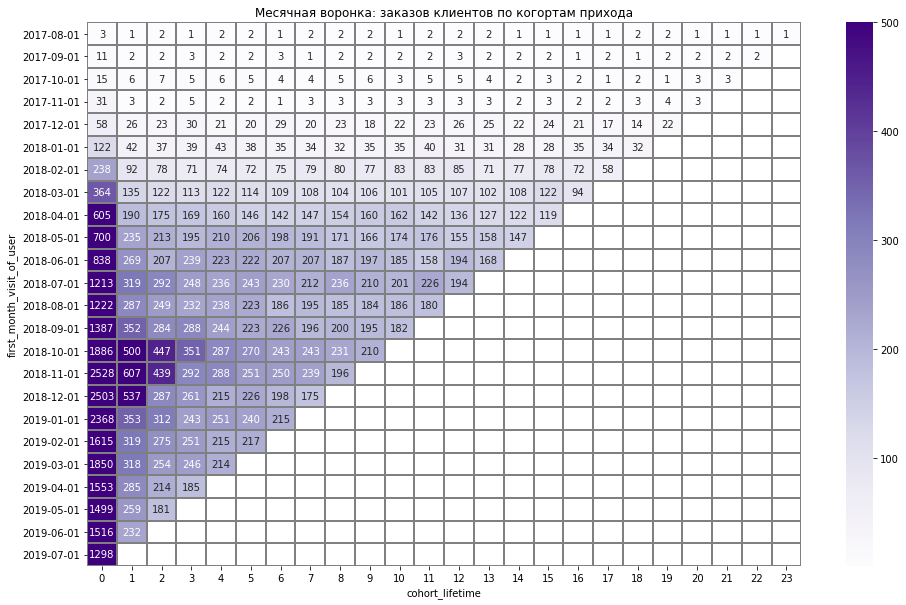

In [99]:
pivot_df=df.pivot_table(index='first_month_visit_of_user', columns='cohort_lifetime',values='client_id',
                        aggfunc='nunique')
make_heatmap('Месячная воронка: заказов клиентов по когортам прихода',pivot_df,'g',500,'Purples')

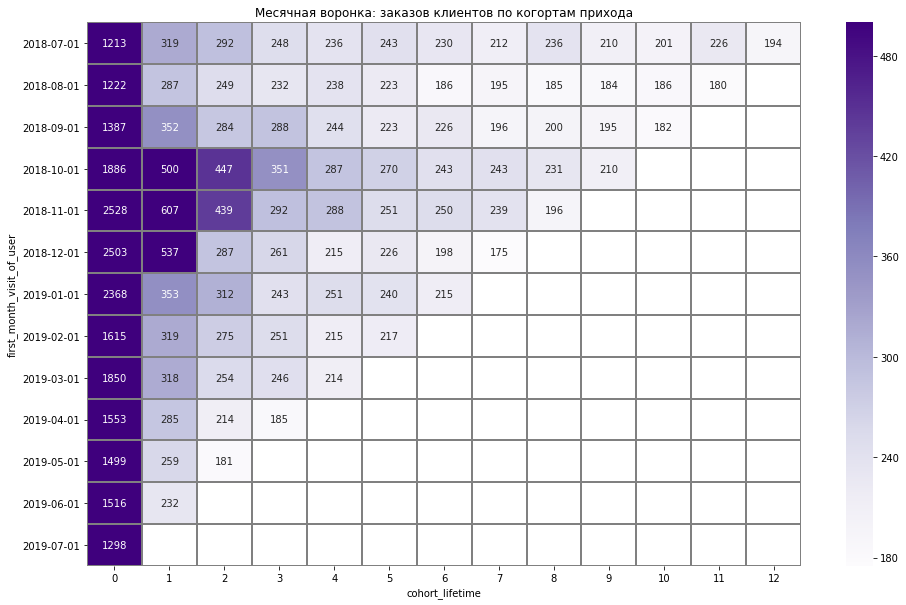

In [100]:
pivot_df1=df.query('first_month_visit_of_user > "2018-06-01 00:00:00"').pivot_table(index='first_month_visit_of_user', columns='cohort_lifetime',values='client_id',aggfunc='nunique')
pivot_df1
make_heatmap('Месячная воронка: заказов клиентов по когортам прихода',pivot_df1,'g',500,'Purples')

Эффективные компании были в октябре - декабрь 2018, retention  у данных кагорт лучший.
Делать осмысленные выводы необходимо вместе  с затратами по источникам привлечения и как развивалась органика.
Сколько денег было влито на привлечение в данные месяцы? Определить насколько трендово предновогодний движение.
Нужны значения органики.


Расситаем показатели Retention Rate (англ. «коэффициент удержания») и Churn Rate (англ. «коэффициент оттока»). Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.

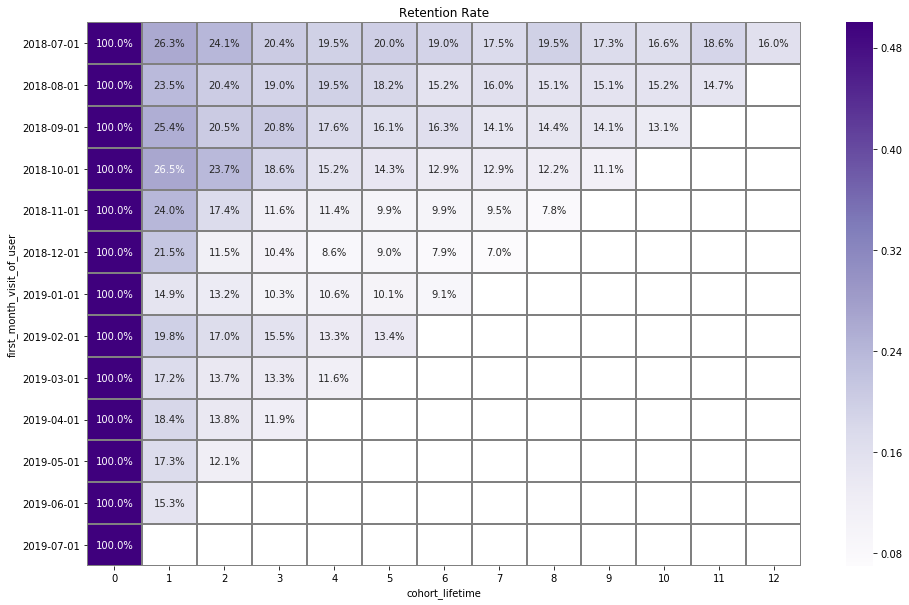

In [101]:
pivot_df1_rt = copy.deepcopy(pivot_df1)
for index in pivot_df1_rt.index.tolist():
    index = str(index)[0:10]
    number=pivot_df1_rt.loc[index, 0]
    for col in pivot_df1.columns.tolist():
        col = str(col)[0:10]
        if pivot_df1_rt.loc[index, int(col)]>0:
            pivot_df1_rt.loc[index, int(col)]=(pivot_df1_rt.loc[index, int(col)]/number)  
make_heatmap('Retention Rate',pivot_df1_rt,'.1%',0.5,'Purples')

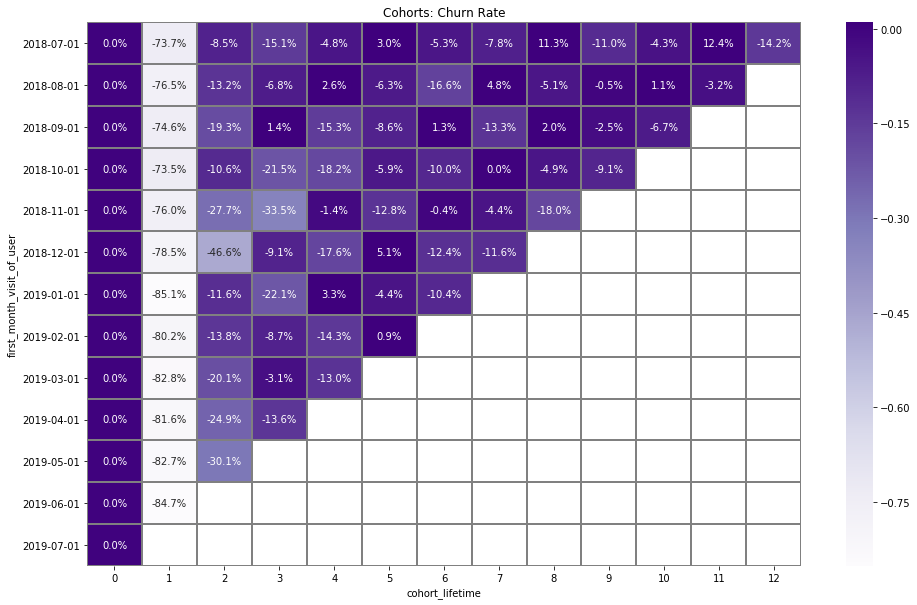

In [102]:
cohorts = df.query('first_month_visit_of_user > "2018-06-01 00:00:00"').groupby(['first_month_visit_of_user','cohort_lifetime']).agg({'client_id':'nunique'}).reset_index()
cohorts['churn_rate'] = cohorts.groupby(['first_month_visit_of_user'])['client_id'].pct_change()
churn_pivot = cohorts.pivot_table(index='first_month_visit_of_user',columns='cohort_lifetime',values='churn_rate',aggfunc='sum')
make_heatmap('Cohorts: Churn Rate',churn_pivot,'.1%',0.01,'Purples')

Анализируя таблицу видно, что наибольший показатель оттока на следующий месяц после прихода пользователей. Затем он снижается, что не меняет общей тенденции оттока пользователей смотря на общую картину. На общем фоне видно аномалию - декабрская кагорта на второй месяц жизни показала худший отток -46,6%, майская тоже на второй месяц - 30%
Что с ними не так, надо разбиратся детально.

In [103]:
#.style.background_gradient(cmap='coolwarm')
df.groupby('month2').agg({'client_id':'nunique','id':'count','agent_amount':'sum','final_price':'sum'}).corr()

,client_id,id,agent_amount,final_price
client_id,1.000000,0.997141,0.994175,0.988762
id,0.997141,1.000000,0.997657,0.995335
agent_amount,0.994175,0.997657,1.000000,0.997285
final_price,0.988762,0.995335,0.997285,1.000000


В какие дни сколько заказов

In [104]:
df_clean = df.query('first_month_visit_of_user > "2018-06-01 00:00:00" & client_id!=@kit_clients_orders')

In [105]:
# средний чек по дням недели
metrick2=df_clean.groupby('weekday').agg({'final_price':'sum','client_id':'count','id':'nunique',}).reset_index()
metrick2['AVG_check']=(metrick2['final_price']/metrick2['id']).round(2)
weekday=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
for i in range(len(metrick2)):
    metrick2.loc[i,'weekday']=weekday[i]
metrick2

,weekday,final_price,client_id,id,AVG_check
0,Monday,9703059.95,8092,8092,1199.09
1,Tuesday,9841655.85,8243,8243,1193.94
2,Wednesday,10470566.60,8584,8584,1219.78
3,Thursday,11466031.75,9318,9318,1230.52
4,Friday,13588213.35,10816,10816,1256.31
5,Saturday,14817657.35,11631,11631,1273.98
6,Sunday,14561077.75,11622,11622,1252.89


In [106]:
def make_graf(table1,col,col2,title):
    fig, ax = plt.subplots(figsize=(15,6))
    plt.plot(table1[col2], table1[col], 'o-')
    plt.text(table1.loc[table1[table1[col]==table1[col].max()].index[0],col2], table1[col].max(),
             int(table1[col].max()), horizontalalignment='center',rotation=0,verticalalignment='bottom',
             fontdict={'fontweight':500, 'size':12})
    ax.set_xticklabels(table1[col2],rotation=45,size=14)
    plt.grid(True)
    plt.title(title,fontsize='xx-large')

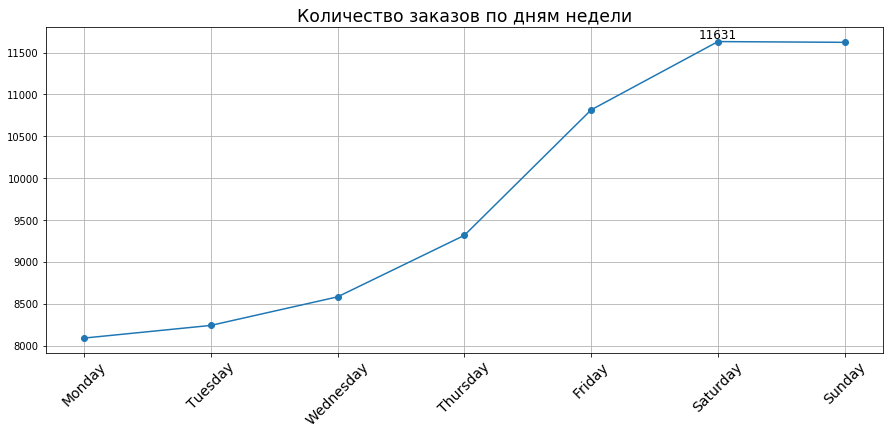

In [107]:
make_graf(metrick2,'id','weekday','Количество заказов по дням недели')

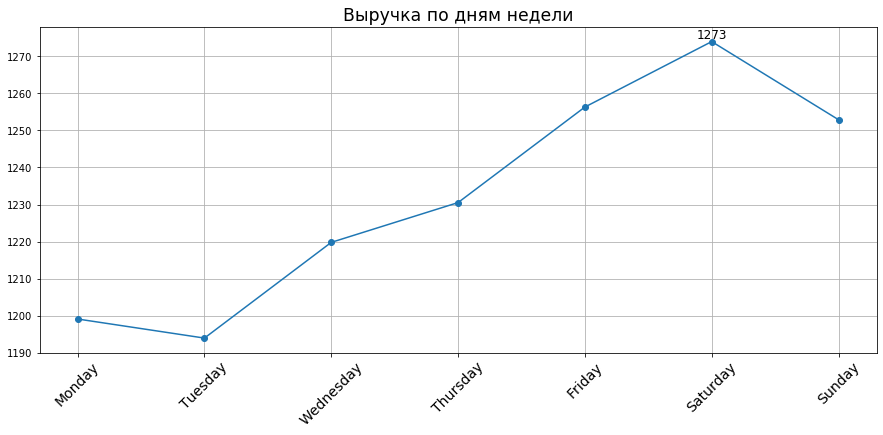

In [108]:
make_graf(metrick2,'AVG_check','weekday','Выручка по дням недели')

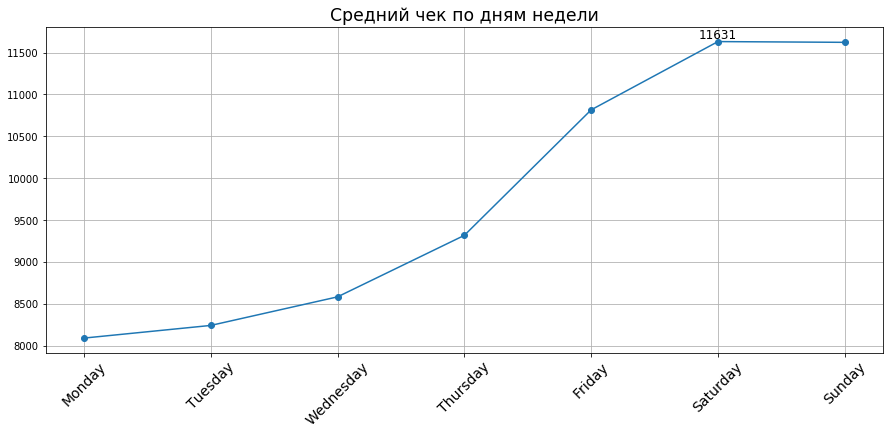

In [109]:
make_graf(metrick2,'id','weekday','Средний чек по дням недели')

In [110]:
# средний чек по дням недели
metrick3=df_clean.groupby('weekday').agg({'final_price':'sum','client_id':'count','id':'nunique',}).reset_index()
metrick3['AVG_check']=(metrick2['final_price']/metrick2['id']).round(2)
weekday=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
for i in range(len(metrick2)):
    metrick2.loc[i,'weekday']=weekday[i]
metrick3

,weekday,final_price,client_id,id,AVG_check
0,0,9703059.95,8092,8092,1199.09
1,1,9841655.85,8243,8243,1193.94
2,2,10470566.60,8584,8584,1219.78
3,3,11466031.75,9318,9318,1230.52
4,4,13588213.35,10816,10816,1256.31
5,5,14817657.35,11631,11631,1273.98
6,6,14561077.75,11622,11622,1252.89


In [111]:
pd.pivot_table(df_clean, index='hour', values=['id'],aggfunc='count',
               columns='weekday').fillna(0).style.background_gradient(cmap='coolwarm')

In [112]:
pd.pivot_table(df_clean.query('state!="finished"'), index='hour', values=['id'],aggfunc='count',
               columns='weekday').fillna(0).style.background_gradient(cmap='coolwarm')

In [113]:
# Заведение отменило заказ
pd.pivot_table(df_clean.query('state=="canceled_place"'), index='hour', values=['id'],aggfunc='count',
               columns='weekday').fillna(0).style.background_gradient(cmap='coolwarm')

In [114]:
# Заведение отменило заказ
pd.pivot_table(df_clean.query('state=="canceled_bb"'), index='hour', values=['id'],aggfunc='count',
               columns='weekday').fillna(0).style.background_gradient(cmap='coolwarm')

In [115]:
pd.pivot_table(df_clean.query('state=="canceled"'), index='hour', values=['id'],aggfunc='count',
               columns='weekday').fillna(0).style.background_gradient(cmap='coolwarm')

# Выводы: 
* Часы пик - с 14 до 17
* Горячие дни по заказам - пятница -воскресенье

Необходимо в эти часы иметь запас курьеров, например для них cделать обязательные часы выхода на работу.

## отмененные заказы

* отменненые заказы есть в часы пик, как по вине заведений, так и по нашей. Эти кейсы необходимо разбирать в деталях и работать по ним.

* количество заказов, которые отменили клиенты невысоко.

In [116]:
df_clean.query('state!="finished"').groupby('delivery_type').agg({'id':'count'})

,id
delivery_type,
default,2743
high_demand,62
long_distance,372
restaurant,138


In [117]:
pd.pivot_table(df_clean.query('state!="finished"'), index='state', values=['id'],aggfunc='count',
               columns='delivery_type')

id                                     
delivery_type  default high_demand long_distance restaurant
state                                                      
canceled          32.0         NaN           7.0        3.0
canceled_bb     1723.0        32.0         240.0       63.0
canceled_place   988.0        30.0         125.0       72.0

In [118]:
# посмотрим есть ли связь статуса high_demand и времени
df_clean.query('delivery_type=="high_demand"').hour.unique()

array([15, 16, 17, 18, 19, 12, 13, 14,  9, 10, 11,  8,  5,  6])

high_demand - это высокий спрос, но привязки ко времени нет, это странно.

In [119]:
# найдем заведения которые больше всех отменяли заказы
canceled_place = df_clean.query('state=="canceled_place"').groupby('place_id').agg(
    {'id':'count'}).sort_values('id',ascending=False).reset_index().head(20)
canceled_place = canceled_place.rename(columns={'id': 'count_of_orders'})

In [120]:
# популярное место заказов
top20_place = df_clean.groupby('place_id').agg({'id':'count'}).sort_values('id',ascending=False).reset_index().head(20)
top20_place = top20_place.rename(columns={'id': 'count_of_orders'})
top20_place['%_of_orders'] = (top20_place.count_of_orders/len(df_clean)*100).round(1)
top20_place

,place_id,count_of_orders,%_of_orders
0,16850670-d37c-4647-b529-28911e16695d,6119,9.0
1,e701df97-0349-4872-a4f4-fd3707ec686d,2940,4.3
2,18f6c6e3-d0a1-4ccb-82fb-6976db97ed9e,2464,3.6
3,4ae8a68c-6622-4c4c-96a5-0f0aacbb7fd8,2300,3.4
4,6fa5208b-5852-4654-b258-3a9d2bfb5a36,2159,3.2
5,76edbec9-20d4-4672-89df-a5527377c5b8,2149,3.1
6,1346e4e6-1e69-4ca8-a965-95a3cba041bc,1636,2.4
7,14b07c54-519e-4e18-89cf-2e919a67ff5c,1317,1.9
8,64f6b4d3-fa23-4f0c-9610-6951afeceec4,1212,1.8
9,e95db384-04ab-4875-b20c-089a3c415140,1193,1.7


In [121]:
top20_place.merge(canceled_place, on = 'place_id',how ='left' ).fillna(0)

,place_id,count_of_orders_x,%_of_orders,count_of_orders_y
0,16850670-d37c-4647-b529-28911e16695d,6119,9.0,39.0
1,e701df97-0349-4872-a4f4-fd3707ec686d,2940,4.3,11.0
2,18f6c6e3-d0a1-4ccb-82fb-6976db97ed9e,2464,3.6,26.0
3,4ae8a68c-6622-4c4c-96a5-0f0aacbb7fd8,2300,3.4,13.0
4,6fa5208b-5852-4654-b258-3a9d2bfb5a36,2159,3.2,19.0
5,76edbec9-20d4-4672-89df-a5527377c5b8,2149,3.1,20.0
6,1346e4e6-1e69-4ca8-a965-95a3cba041bc,1636,2.4,19.0
7,14b07c54-519e-4e18-89cf-2e919a67ff5c,1317,1.9,0.0
8,64f6b4d3-fa23-4f0c-9610-6951afeceec4,1212,1.8,0.0
9,e95db384-04ab-4875-b20c-089a3c415140,1193,1.7,0.0


Самая популярное завезение по заказам это "16850670-d37c-4647-b529-28911e16695d" - 10,3% всех заказов 

### неплохо было бы отследить, если у клиента была отмена заказа, возвращался ли он к нам и что мы сделали для его возврата?!

In [122]:
df[df.columns[20:]].head()

,prepaire_time,delivery_time,waiting_order,dt,weekday,hour,month,month2,year,week,client_bonus,first_visit_of_user,first_month_visit_of_user,cohort_lifetime
0,222.0,0 days,0.0,2017-08-15,1,10,8,2017-08-01,2017,33,0.0,2017-08-15 10:18:16.390,2017-08-01,0
1,210.0,0 days,0.0,2017-08-15,1,14,8,2017-08-01,2017,33,0.0,2017-08-15 10:18:16.390,2017-08-01,0
2,198.0,0 days,0.0,2017-08-15,1,15,8,2017-08-01,2017,33,0.0,2017-08-15 10:18:16.390,2017-08-01,0
3,201.0,0 days,0.0,2017-08-16,2,13,8,2017-08-01,2017,33,0.0,2017-08-15 10:18:16.390,2017-08-01,0
4,197.0,0 days,0.0,2017-08-17,3,20,8,2017-08-01,2017,33,0.0,2017-08-15 10:18:16.390,2017-08-01,0


In [123]:
df[df.client_bonus==200].client_id.nunique()

1555

In [124]:
df[df.client_bonus==200].client_id.nunique()/df.client_id.nunique()

0.06116508673248633

клиенты которые делают заказы в определенные дни

In [126]:
df_clean.groupby('client_id').agg({'week':'nunique'})

,week
client_id,
00000220-a7ba-45cc-a38d-83cd28e44b4a,1
00031ecb-b5a3-4a89-9089-703e0411ddbb,1
0003a201-62eb-4e53-80cf-a1723c03b232,1
0003f07c-9b9c-4714-a51c-c5137ad1b537,1
000565ac-9c98-4f72-a999-d0b75116fb69,6
...,...
fff41a18-a49e-4ab9-8215-60326efa6b80,1
fff6fb36-1f50-4db5-8453-2af03b234911,2
fff72486-7117-47d2-944b-53f149d99573,1


In [127]:
xxx = pd.pivot_table(df_clean, index='client_id', values=['id'],
               aggfunc='count',columns='weekday').fillna(0)
xxx.columns = xxx.columns.droplevel(0)
yyy = pd.pivot_table(df_clean, index='client_id', values=['id'],
               aggfunc='count')
yyy = yyy.rename(columns={'id': 'cumsum'})
xxx = xxx.merge(yyy, on='client_id').reset_index()
zzz = df_clean.groupby('client_id').agg({'week':'nunique'})
xxx = xxx.merge(zzz, on='client_id').sort_values('cumsum', ascending=False)
xxx = xxx.rename(columns={0:'Monday',1: 'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',
                          5:'Saturday',6:'Sunday'})

xxx.head(20)

,client_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,cumsum,week
3319,27306881-7e8b-4369-b2e5-0e74872ecc1e,4.0,10.0,9.0,6.0,7.0,6.0,8.0,50,23
20687,ed06b95d-4583-46b4-8528-d3ef46c9cc81,4.0,7.0,6.0,7.0,8.0,10.0,8.0,50,22
6425,4a9cf417-9e7b-4197-b2ba-e020880ced6a,5.0,9.0,6.0,10.0,4.0,9.0,7.0,50,17
9173,698648cb-5740-41fa-9510-13d9ec36c8cc,5.0,11.0,5.0,5.0,9.0,4.0,10.0,49,33
19256,dc9d2209-3a28-4a1d-880d-42561ed65df3,3.0,4.0,3.0,11.0,6.0,11.0,11.0,49,30
6968,5099f871-34eb-4fa4-833e-211e627faf8f,6.0,6.0,7.0,9.0,5.0,5.0,10.0,48,27
10574,79040482-c828-4814-80f8-0f635c901580,12.0,9.0,4.0,9.0,3.0,6.0,5.0,48,30
17032,c2757d07-ceac-4c90-8f2b-56df09f065ad,5.0,9.0,6.0,7.0,7.0,10.0,4.0,48,25
19182,dbdbc53b-1fb3-4912-8bb2-12dc9429bac7,5.0,5.0,7.0,3.0,6.0,11.0,11.0,48,20
5751,4338d1ae-cc08-4409-9c37-2c5a28ea80b0,3.0,9.0,4.0,6.0,11.0,6.0,8.0,47,24
